# Using PyAirbyte as a data orchestrator for hosted Airbyte connections
This demo showcases how to automate and monitor Airbyte Cloud sync jobs using PyAirbyte. It includes setting up job executions, handling dependencies, sending real-time status updates, and visually representing job details and outcomes on a timeline.

In [ ]:
# Add virtual environment support for running in Google Colab
!apt-get install -qq python3.10-venv

# Install PyAirbyte
%pip install --quiet airbyte

## Job execution and notifications using PyAirbyte
Here, we initialize an Airbyte Cloud workspace with PyAirbyte to manage data sync jobs. We show how Slack can be used for real-time notifications on job statuses.

The code below does the following:

- Workspace initialization: Sets up the workspace with necessary credentials.
- Slack notifications: Configures a webhook for sending job statuses to a Slack channel.
- Job data tracking: Collects and stores execution details like start time, duration, and status for visualization.
- Run syncs: Executes jobs sequentially based on dependency success and sends detailed outcomes to Slack (or simply print them).

In [ ]:
import requests
from airbyte import cloud
from datetime import datetime
from google.colab import userdata

# Initialize the Airbyte Cloud workspace
workspace = cloud.CloudWorkspace(
    workspace_id=userdata.get("AIRBYTE_WORKSPACE_ID"),
    api_key=userdata.get("AIRBYTE_API_KEY"),
)

# Slack webhook URL - replace with your actual Slack webhook URL
slack_webhook_url = "https://hooks.slack.com/services/XXX/YYY/ZZZ"

# Initialize job data for visualization
job_data = []

def send_slack_message(message, webhook_url):
    """Sends a message to a Slack channel specified by the webhook URL."""
    payload = {'text': message}
    response = requests.post(webhook_url, json=payload)
    return response.status_code

def trigger_sync_and_check(connection_id):
    """Triggers a sync job for a specified connection ID and checks the job status."""
    start_time = datetime.now()
    connection = workspace.get_connection(connection_id=connection_id)
    sync_result = connection.run_sync()
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    status = str(sync_result.get_job_status())

    # Store job data for visualization
    job_data.append({
        'connection_id': connection_id,
        'start_time': start_time,
        'end_time': end_time,
        'duration': duration,
        'status': status
    })

    return status, sync_result, start_time, duration

def format_sync_details(sync_result, start_time, duration):
    """Format sync details for Slack message, including start time and duration."""
    details = (
        f"Job ID: {sync_result.job_id}\n"
        f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"Duration: {duration:.2f} seconds\n"
        f"Records Synced: {sync_result.records_synced}\n"
        f"Bytes Synced: {sync_result.bytes_synced}\n"
        f"Job URL: {sync_result.job_url}"
    )
    return details

def run_syncs():
    """Handle sequential sync jobs where the second job depends on the success of the first."""
    # Connection IDs for the two jobs. Replace with your connection IDs
    first_connection_id = "df2898ce-b21f-43c0-8c82-bd8c6dd24931"
    second_connection_id = "86075252-9004-41fc-b5e3-f61f20388ff5"

    first_status, first_sync_result, first_start, first_duration = trigger_sync_and_check(first_connection_id)
    if "SUCCEEDED" in first_status:
        message = f"First sync succeeded (Connection ID: {first_connection_id}).\nDetails:\n{format_sync_details(first_sync_result, first_start, first_duration)}\nProceeding to second sync."
        send_slack_message(message, slack_webhook_url)
        print(message)

        second_status, second_sync_result, second_start, second_duration = trigger_sync_and_check(second_connection_id)
        if "SUCCEEDED" in second_status:
            message = f"Second sync succeeded (Connection ID: {second_connection_id}).\nDetails:\n{format_sync_details(second_sync_result, second_start, second_duration)}"
        else:
            message = f"Second sync failed (Connection ID: {second_connection_id}). Status: {second_status}\nDetails:\n{format_sync_details(second_sync_result, second_start, second_duration)}"
    else:
        message = f"First sync failed (Connection ID: {first_connection_id}). Status: {first_status}\nDetails:\n{format_sync_details(first_sync_result, first_start, first_duration)}\nSecond sync not initiated."

    send_slack_message(message, slack_webhook_url)
    print(message)

In [ ]:
run_syncs()

First sync succeeded (Connection ID: df2898ce-b21f-43c0-8c82-bd8c6dd24931).
Details:
Job ID: 10575770
Start Time: 2024-04-16 20:08:57
Duration: 155.78 seconds
Records Synced: 2100
Bytes Synced: 766685
Job URL: https://api.airbyte.com/v1/workspaces/ab2f3ba2-94e6-45b9-9d26-58b3f1d52295/connections/df2898ce-b21f-43c0-8c82-bd8c6dd24931/job-history/10575770
Proceeding to second sync.
Second sync succeeded (Connection ID: 86075252-9004-41fc-b5e3-f61f20388ff5).
Details:
Job ID: 10575853
Start Time: 2024-04-16 20:11:32
Duration: 123.54 seconds
Records Synced: 1
Bytes Synced: 214665
Job URL: https://api.airbyte.com/v1/workspaces/ab2f3ba2-94e6-45b9-9d26-58b3f1d52295/connections/86075252-9004-41fc-b5e3-f61f20388ff5/job-history/10575853


## Job execution timeline visualization
With the data collected from the syncs we previously ran using PyAirbyte, we can create a visualization that provides a clear and intuitive representation of a series of job executions over time.

Each job is displayed as a rectangle along a timeline, where the width of each rectangle corresponds to the job's duration. The colors indicate the status of each job—green for successful completions and yellow for failures. This graph is particularly useful for quickly assessing the overall health and efficiency of a workflow. It allows viewers to see at a glance:

- Job Durations: How long each job took to complete.
- Job Start Times: When each job began relative to the start of the timeline.
- Job Outcomes: The success or failure of each job.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime, timedelta

def get_color(status):
    """Returns color based on the job status."""
    if "SUCCEEDED" in status:
        return 'green'  # Green for success
    elif "FAILED" in status:
        return 'yellow'  # Yellow for failure
    else:
        return 'gray'  # Gray for any other status

def draw_job_graph(job_data):
    """Draws a graph of job executions where rectangles represent the duration and color indicates status."""
    fig, ax = plt.subplots(figsize=(14, 3))

    # Start position and time tracking
    start_time = min(job['start_time'] for job in job_data)  # Find the earliest start time
    end_time = max(job['start_time'] + timedelta(seconds=job['duration']) for job in job_data)  # Find the latest end time
    total_duration = (end_time - start_time).total_seconds()

    for job in job_data:
        start_offset = (job['start_time'] - start_time).total_seconds()
        width = job['duration']  # Duration in seconds
        color = get_color(job['status'])  # Get color based on job status
        rect = patches.Rectangle((start_offset, 0), width, 1, linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

        # Adding text inside the rectangle
        ax.text(start_offset + width / 2, 0.5, f"{job['connection_id']} ({job['duration']}s)",
                verticalalignment='center', horizontalalignment='center', color='black', fontweight='bold')

    # Set the limits and labels of the x-axis
    ax.set_xlim(0, total_duration)
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlabel("Time (seconds from start)")
    ax.set_title('Job Execution Timeline')
    plt.xticks(range(0, int(total_duration) + 1, 20))  # Set x-ticks to appear every 20 seconds
    plt.yticks([])
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
    plt.show()

## Visualize sync results

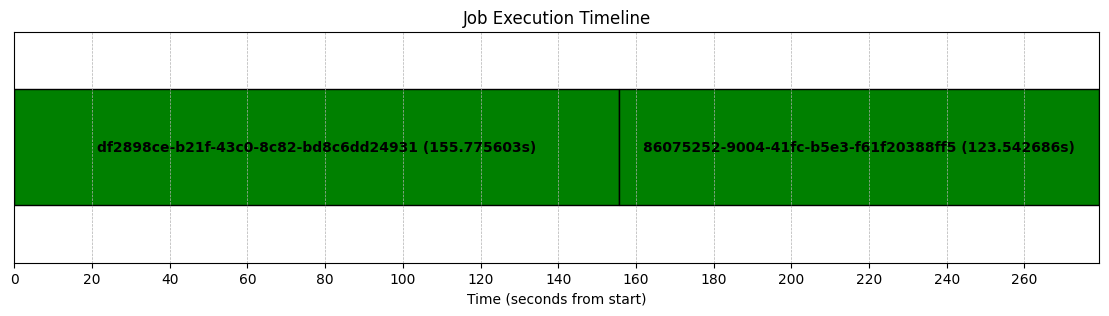

In [ ]:
draw_job_graph(job_data)